# Metric v2 vis
Based on Metric v1, but now exploring QuadTree binning

but now make the viz more "normal", aim for paper/proposals

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import LogNorm

import sys
sys.path.append('/Users/james/python/qthist2d/')
# from QThist import QThist, QTcount
from qthist2d import qthist, qtcount

In [2]:
cpunk = False

import matplotlib
matplotlib.rcParams.update({'font.size':18})

if cpunk:
    import mplcyberpunk
    plt.style.use("cyberpunk")
else:
    matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# smooth both EBs and Stars w/ a 2D Gaussian KDE
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xmin=-1, xmax = 5.5, ymin= -6, ymax=16,
          xbins=100j, ybins=100j, **kwargs): 
    """
    Build a 2D kernel density estimate (KDE)
    https://stackoverflow.com/a/41639690
    """

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[xmin:xmax:xbins, 
                      ymin:ymax:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [4]:
denominator = pd.read_csv('gaia_tess2min.csv')

Dok = ((denominator['parallax'] > 0) & 
       np.isfinite(denominator['bp_rp']) & 
       np.isfinite(denominator['phot_g_mean_mag']))

# do the 2d KDE smoothing thing (slow)
xx2, yy2, zz2 = kde2D(denominator['bp_rp'][Dok], 
                      denominator['phot_g_mean_mag'][Dok] - 5. * np.log10(1000./denominator['parallax'][Dok]) + 5, 
                      0.1)

In [5]:
EHow = pd.read_csv('Erin_and_Known_EBs.csv')
Eok = ((EHow['parallax'] > 0) & 
       np.isfinite(EHow['bp_rp']) & 
       np.isfinite(EHow['phot_g_mean_mag']))

In [6]:
x = EHow['bp_rp'][Eok]
y = EHow['phot_g_mean_mag'][Eok] - 5. * np.log10(1000./EHow['parallax'][Eok]) + 5

num, xmin, xmax, ymin, ymax = qthist(x,y, N=7, thresh=3, density=False, rng=[[-1.1,4.1],[-6,15]])

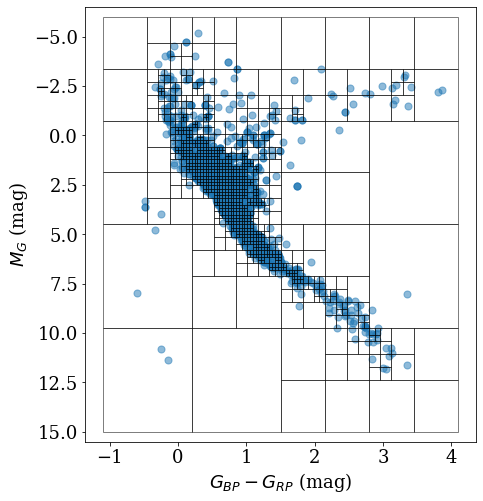

In [7]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)

plt.scatter(x,y, s=50, alpha=0.5, rasterized=True)

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc ='none', lw=1, alpha=0.5, color='k'))

plt.gca().invert_yaxis()
plt.ylim(15.5,-6.5)

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.savefig('QT_bins_v2.2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [8]:
x2 = denominator['bp_rp'][Dok]
y2 = denominator['phot_g_mean_mag'][Dok] - 5. * np.log10(1000./denominator['parallax'][Dok]) + 5

# using Quad Tree bins defined from EB sample, count the background sample
num2 = qtcount(x2, y2, xmin, xmax, ymin, ymax, density=False)


In [9]:
# do a normal 2d histogram (fast), if not the 2D KDE above
# zz2, xx2, yy2, img = plt.hist2d(x2,y2, bins=75)
# print(zz2.shape, xx2.shape, yy2.shape)

# The Score

The importance score for EBs within the $i$'th QuadTree bin of the CMD is defined as:
$$score_i = 1 - \frac{d_{EB,i} + 1}{ d_{bkgd,i} + 1}$$

where the densities for the EB's are defined using the number of EB's in the bin ($N_{EB,i}$), the area of the bin ($a_i$), and the total number of EBs across the CMD ($\sum N_{EB}$):

$$ d_{EB,i} = N_{EB,i}\, / a_i\, / \sum N_{EB} $$

The background star density is defined similarly:
$$ d_{bkgd,i} = N_{bkgd,i}\, / a_i\, / \sum N_{bkgd} $$

In [10]:
def EBscore(num, num2, xmin, xmax, ymin, ymax):
    '''
    compute the Eclipsing Binary rarity score
    assumes the number counts in each bin are NOT densities
    '''
    areas = np.abs(ymax - ymin) * np.abs(xmax - xmin)
    d_EB = num / areas / num.sum() + 1
    d_bk = num2 / areas / num2.sum() + 1
    SCORE = 1 - (d_EB/d_bk)
    return SCORE*100

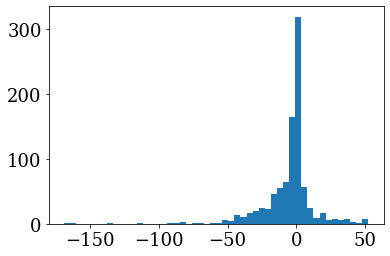

In [11]:
# Now the new QT Score approach:
# areas =(ymax - ymin) * (xmax - xmin)
# SCORE = (1 - (num / areas / num.sum() + 1) / (num2 / areas / num2.sum()+1)) * 100

SCORE = EBscore(num, num2, xmin,xmax,ymin,ymax)
_ = plt.hist(SCORE,bins=50)

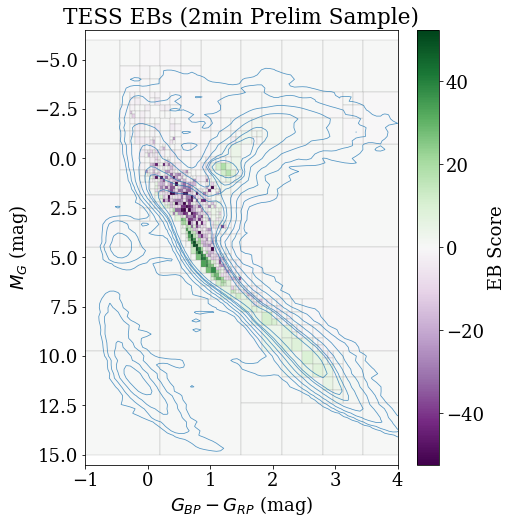

In [12]:
# clip the distribution, center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)
    
# SCORE[SCORE > 25] = 25
# SCORE[SCORE < -25] = -25
    
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.PRGn

# if doing the 2d Histogram for background (fast, but ratty)
# plt.contour((xx2[1:]+xx2[:-1])/2., (yy2[1:]+yy2[:-1])/2., 
#             zz2.T / np.sum(zz2)*np.float(len(Dok)), colors='C0', alpha=0.5, 
#             levels=(3,10,100,500))

# if doing the 2d KDE (slow, but smoother) for background illustration
plt.contour(xx2, yy2, zz2/np.sum(zz2)*np.float(len(Dok)), 
            colors='C0', levels=(1,3,10,30,70,100,200), alpha=0.75, linewidths=0.8)

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('EB Score')


plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.grid(True)

# plt.xlim(min(x), max(x))
# plt.ylim(max(y), min(y))
plt.ylim(15.5,-6.5)
plt.xlim(-1,4)

plt.title('TESS EBs (2min Prelim Sample)')
plt.savefig('score_v2.2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 1.0, '2K RANDOM STARS')

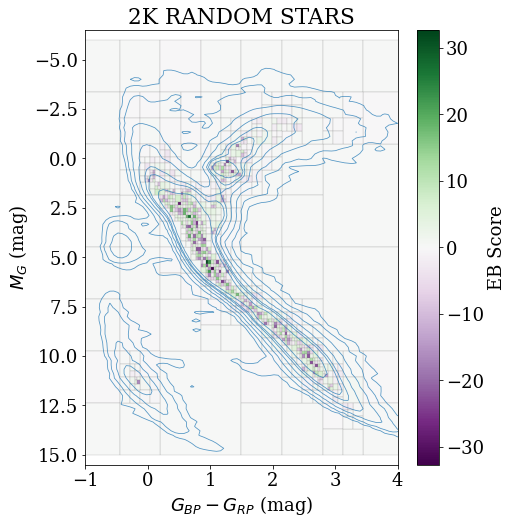

In [13]:
# lets try some simple tests: what if our EBs were drawn
# TRULY randomly from the background distribution?

kr = np.random.randint(0, len(denominator['bp_rp'][Dok]), 2000)
xr = x2.values[kr]
yr = y2.values[kr]

num, xmin, xmax, ymin, ymax = qthist(xr,yr, N=7, thresh=3, density=False, 
                                     rng=[[-1.1,4.1],[-6,15]])

num2 = qtcount(x2, y2, xmin, xmax, ymin, ymax, density=False)
SCORE = EBscore(num, num2, xmin,xmax,ymin,ymax)

# clip the distribution, center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)
    
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.PRGn
plt.contour(xx2, yy2, zz2/np.sum(zz2)*np.float(len(Dok)), 
            colors='C0', levels=(1,3,10,30,70,100,200), alpha=0.75, linewidths=0.8)

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('EB Score')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.ylim(15.5,-6.5)
plt.xlim(-1,4)

plt.title('2K RANDOM STARS')
# plt.savefig('score_v2.2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

# not a solution - the EBs don't follow the same CMD distribution

Text(0.5, 1.0, '2K RANDOM + OFFSET')

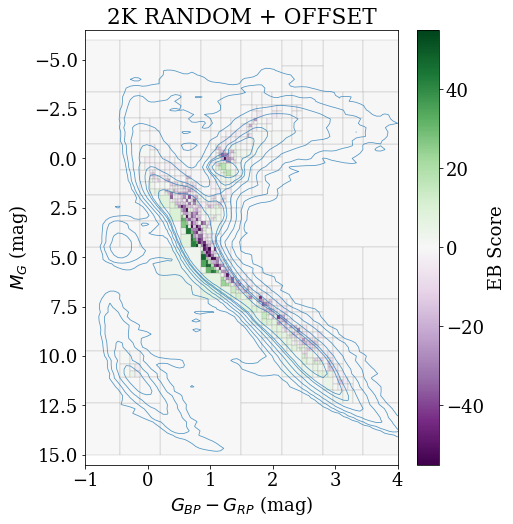

In [14]:
# what if 2k stars are randomly drawn, but are systematically brighter 
# e.g. mostly high mass ratio systems

kr = np.random.randint(0, len(denominator['bp_rp'][Dok]), 2000)
xr = x2.values[kr]
yr = y2.values[kr] - 0.6

num, xmin, xmax, ymin, ymax = qthist(xr,yr, N=7, thresh=3, density=False, 
                                     rng=[[-1.1,4.1],[-6,15]])

num2 = qtcount(x2, y2, xmin, xmax, ymin, ymax, density=False)
SCORE = EBscore(num, num2, xmin,xmax,ymin,ymax)

# clip the distribution, center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)
    
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.PRGn
plt.contour(xx2, yy2, zz2/np.sum(zz2)*np.float(len(Dok)), 
            colors='C0', levels=(1,3,10,30,70,100,200), alpha=0.75, linewidths=0.8)

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('EB Score')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.ylim(15.5,-6.5)
plt.xlim(-1,4)

plt.title('2K RANDOM + OFFSET')
# plt.savefig('score_v2.2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)

# this definitely accounts for SOME of what we see in the actual data, as predicted

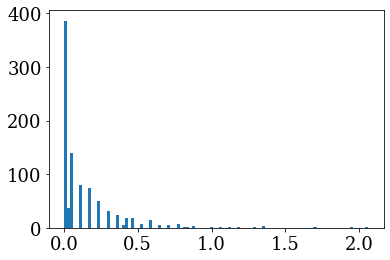

In [21]:
SCORE, xmin, xmax, ymin, ymax = qthist(x,y, N=7, thresh=3, density=True, rng=[[-1.1,4.1],[-6,15]])

_ = plt.hist(SCORE,bins=100)

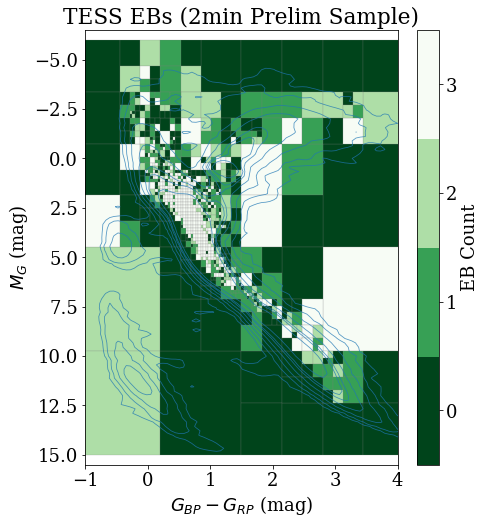

In [52]:
# another easy metric is: where are there simply NO EBs?
# this is just a histogram, of course, using our fun Quad Tree

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
CMAP = plt.cm.Greens_r

# if doing the 2d KDE (slow, but smoother) for background illustration
plt.contour(xx2, yy2, zz2/np.sum(zz2)*np.float(len(Dok)), 
            colors='C0', levels=(1,3,10,30,70,100,200), alpha=0.75, linewidths=0.8)

SCORE, xmin, xmax, ymin, ymax = qthist(x,y, N=7, thresh=3, density=False, rng=[[-1.1,4.1],[-6,15]])
SCORE[SCORE > 3] = 3
# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))

for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='grey', lw=0.2, ))

img = plt.scatter(xmin, ymin, c=SCORE, cmap=CMAP)
img.set_visible(False) # throw this away

cb = plt.colorbar(boundaries=np.arange(-.5, 4, 1), ticks = [0,1,2,3])
cb.set_label('EB Count')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.ylim(15.5,-6.5)
plt.xlim(-1,4)

plt.title('TESS EBs (2min Prelim Sample)')
plt.savefig('EBcount.pdf', dpi=300, bbox_inches='tight', pad_inches=0.25)